# TfL Lump

A cursory exploration of the Transport for London system and its open data API.

The package implements a modest wrapper around a very small portion of the [TfL open data](https://tfl.gov.uk/info-for/open-data-users/) API facilitating fetching of core public transport modes ('bus', 'tube', 'overground', etc). For analysis purposes fetched data is cached to local files. Store objects make the data available as Pandas dataframes and enable writing out as JSON.

As a view into a large scale, highly managed, operational system the TfL open data is formatted for targeted queries rather than static analysis. For the purposes of this cursory analysis project only a small subset of the Mode, Line, and StopPoint APIs have been implemented in the package. Response data has been mapped to more modest dictionaries using Pydantic models for validation and organization. Two primary Store classes provide file cached data backed by rate-limited fetching from the API. 

- The `LineStore` class handles data for a single TfL Mode and gives access to the Lines of that mode as well as each Line's available routes. 

- The `StopPointStore` class indexes individual StopPoints which may be shared across routes. 

<sub>Powered by TfL Open Data. Contains OS data © Crown copyright and database rights 2016 and Geomni UK Map data © and database rights [2019]</sub>

In [1]:
"""Imports and global configuration."""
import datetime as dt
import itertools
import json
import re
import warnings

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

# tflump
from tflump import Direction, LineStore, get_tfl_client

warnings.filterwarnings("ignore")

# matplotlib
plt.rcParams["figure.dpi"] = 512

# seaborn
sns.set_style("ticks", {"axes.grid": False})

# colors
superloop_palette = ["#57575A", "#273890", "#2094A2", "#EF4322"]

In [2]:
"""Load LineStore for mode `bus` and retrieve dataframe."""

bus_store = LineStore(mode="bus")
bus_store.load()

bus_df = bus_store.dataframe()

# Count route sections per line
bus_df["route_count"] = bus_df["route_sections"].map(len)


bus_df.head(3)

,id,name,mode_name,route_sections,service_types,route_count
0,1,1,bus,[{'name': 'Royal Free Hospital - Canada Water ...,[Regular],2
1,100,100,bus,[{'name': 'King Edward Street / St Pauls Stati...,[Regular],2
2,101,101,bus,[{'name': 'Woodbine Place - Beckton Bus Statio...,[Regular],2


In [3]:
"""Retrieve the stop point dataframe from the LineStore."""

stoppoint_df = bus_store.stoppoint_store().dataframe()

stoppoint_df.head(3)

,id,stop_letter,name,lat,lon,lines,modes,parent_id,station_id,top_most_parent_id
0,490011760D,D,Royal Free Hospital,51.553947,-0.165511,"[1, 46, c11]",[bus],490G000732,490G000732,490G000732
1,490011714E,E,Rosslyn Hill,51.553441,-0.168286,"[1, 46, c11]",[bus],490G00011714,490G00011714,490G00011714
2,490015255F,F,Haverstock Hill / Pond Street,51.552266,-0.167295,"[1, 268, c11, n5]",[bus],490G00015255,490G00015255,490G00015255


## Overview

In [4]:
"""Utility functions for expanding nested columns."""


def dict_to_series(dct: dict, pre: str) -> pd.Series:
    """Convert a encoded dict to a Series."""
    keys, values = zip(*list(dct.items()))

    return pd.Series(values, index=[f"{pre}{k}" for k in keys])


def explode_dict(
    row: pd.Series,
    col: str,
    pre: str = "",
    drop_row: bool = False,
) -> pd.Series:
    """Expand dict column to individual columns by keys."""
    dict_series = dict_to_series(row[col], pre)

    concat_row = pd.concat([row, dict_series])

    if drop_row:
        concat_row = concat_row.drop(labels=[col])

    return concat_row

### Lines 

At the time of fetching Transport for London was operating **677** bus lines serving **19,974** individual stop points. 

The majority of bus lines have 2 individual routes: an outbound journey and an inbound journey covering the same corridor as road/traffic constraints allow.

Exceptions to this are:

- Routes flagged as *outbound only*, which travel in one direction only (ie. 628 — Jewish Free School - Southgate Station).  
These are all marked as having an *outbound* direction.

- Routes with multiple origination points or cyclic service. 

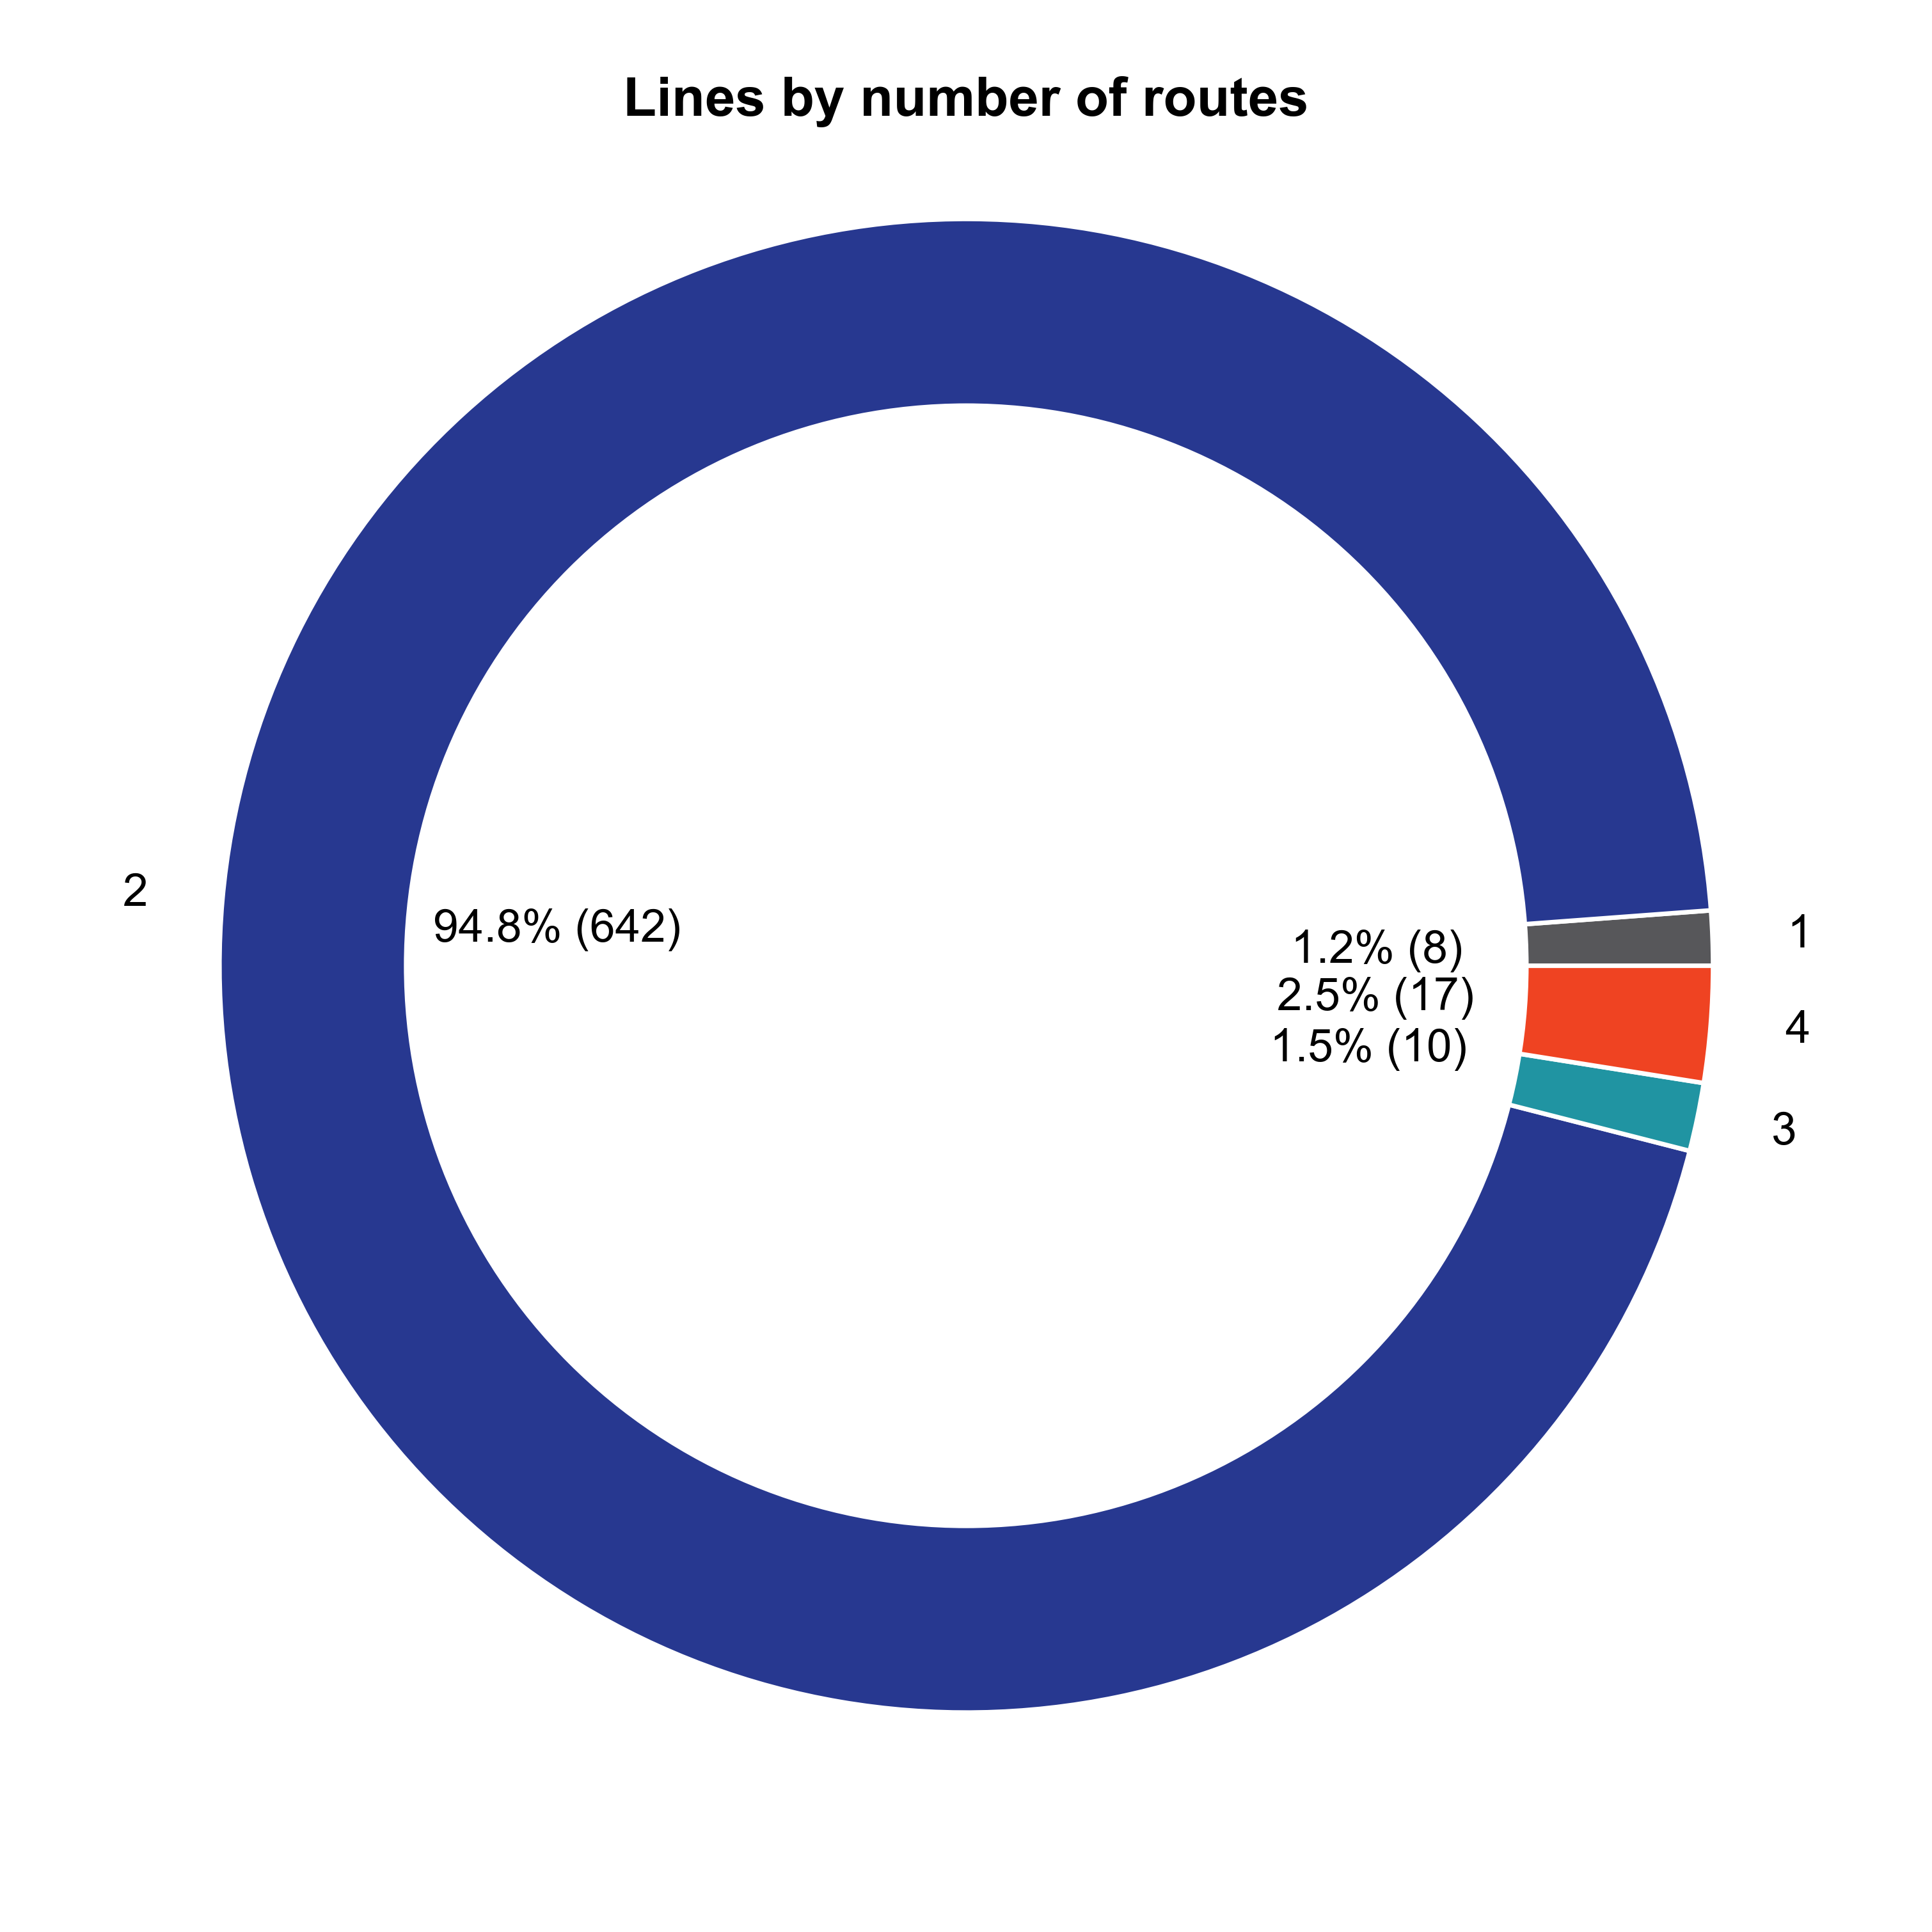

In [5]:
"""Overview of line and route counts. (Bus lines: 677 — Stop points: 19974)"""

# print(f"  Bus lines: {len(bus_df)} — Stop points: {len(stoppoint_df)}")

# print(bus_df["route_count"].value_counts())


# plot lines by number of route sections.
data = bus_df.groupby("route_count").size().fillna(0).sort_index()

fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor="white")

ax.pie(
    data,
    labels=data.index,
    autopct=lambda x: f"{x:.1f}% ({sum(data) * x / 100:.0f})",
    pctdistance=0.55,
    colors=superloop_palette,
    textprops={"color": "black"},
)
fig.text(
    0.5,
    0.94,
    "Lines by number of routes",
    color="black",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=12,
    fontweight="bold",
    fontfamily="sans-serif",
)

centre_circle = plt.Circle((0, 0), 0.75, fc="white")

fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
# ax.axis('equal')
plt.tight_layout()
plt.show();

### Stops

If we expand the line data by their route sections we can look a look for trends in line design by TfL. 

As a starting point we can look at: 
 
- The number of stop points each line serves

- The congruency of *inbound* and *outbound* routes in terms of path and stop points

- The length of routes both overall and between stop points

- The orientation of routes 

In [6]:
"""Utility functions for geo analysis"""


def parse_linestrings(
    linestrings: list[str],
    reverse: bool = True,
) -> list[list[tuple[float, float]]]:
    """Parse a nested JSON linestring array and reverse coordinate order.

    Parameters:
    linestrings : list[str]
        A list containing encoded JSON strings

    reverse : bool = True
        If `True` reverses the coordinate order.

    Note:
    TfL encodes linestrings as `[lon, lat]` pairs but folium expects `[lat, lon]`.
    """
    parsed = next(map(json.loads, linestrings))
    if reverse:
        return [[[lat, lon] for lon, lat in line] for line in parsed]

    return parsed

In [7]:
"""Expand bus lines by `route_sections`."""


bus_routes_df = (
    bus_df.explode("route_sections")
    .reset_index(drop=True)
    .copy()
    .apply(
        lambda r: explode_dict(r, "route_sections", "route_", drop_row=True),
        axis=1,
    )
)

bus_routes_df.head(3)

,id,name,mode_name,service_types,route_count,route_name,route_direction,route_origination_name,route_destination_name,route_originator,route_destination,route_service_type,route_valid_to,route_valid_from,route_is_outbound_only,route_line_strings,route_ordered_line_routes
0,1,1,bus,[Regular],2,Royal Free Hospital - Canada Water Bus Station,outbound,Royal Free Hospital,Canada Water Bus Station,490011760D,490004733D,Regular,2024-12-23 00:00:00+00:00,2024-07-06 00:00:00+00:00,False,"[[[[-0.165413,51.554097],[-0.165797,51.554005]...","[[490011760D, 490011714E, 490015255F, 49000002..."
1,1,1,bus,[Regular],2,Canada Water Bus Station - South End Green,inbound,Canada Water Bus Station,South End Green,490004733C,490012280N,Regular,2024-12-23 00:00:00+00:00,2024-07-06 00:00:00+00:00,False,"[[[[-0.049903,51.497756],[-0.049621,51.4976],[...","[[490004733C, 490011723E, 490013042J, 49000022..."
2,100,100,bus,[Regular],2,King Edward Street / St Pauls Station - St Geo...,outbound,King Edward Street / St Pauls Station,St George's Town Hall / Shadwell Stn,490008743N,490012020A,Regular,2024-12-23 00:00:00+00:00,2024-07-06 00:00:00+00:00,False,"[[[[-0.098569,51.516554],[-0.098571,51.516785]...","[[490008743N, 49008743N1, 490010130N, 49000381..."


In [8]:
"""Folium plotting utility functions"""

import geopandas as gpd
import shapely
from shapely.geometry import LineString, Point


direction_palette = {
    Direction.INBOUND: ["#EF4423", "#F7941C"],
    Direction.OUTBOUND: ["#283991", "#2094A2"],
}


def plot_route(
    line_id: str,
    directions: [Direction] = None,
):
    """Plot route sequences for the indicated directions."""
    if directions is None:
        directions = [Direction.INBOUND, Direction.OUTBOUND]

    bus_line = (
        bus_routes_df.loc[
            (bus_routes_df["id"] == line_id)
            & (bus_routes_df["route_direction"].isin(directions)),
        ]
        .copy()
        .reset_index()
    )

    # Filter bus routes by line_id and direction
    line_routes = bus_line[["route_direction", "route_line_strings"]]

    # Parse JSON encoded line_strings
    # NOTE: Reverses coordinate order `[lon, lat]` -> `[lat, lon]`
    line_routes["route_line_strings"] = line_routes["route_line_strings"].apply(
        parse_linestrings,
    )

    # Flatten all route coordinates into a single list
    all_points = next(
        itertools.chain.from_iterable(line_routes["route_line_strings"].tolist()),
    )

    # Parse JSON encoded line_strings
    # NOTE: Reverting point order `[lat, lon]` -> `[lon, lat]`
    all_points_geo = LineString([Point([lon, lat]) for lat, lon in all_points])

    # Bounds
    min_lon, min_lat, max_lon, max_lat = all_points_geo.bounds
    sw = [min_lat, min_lon]
    ne = [max_lat, max_lon]
    bounds_center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]

    # Route metrics
    centroid = shapely.centroid(all_points_geo)
    c_lat = centroid.y
    c_lon = centroid.x
    c_v = [[max_lat, c_lon], [min_lat, c_lon]]
    c_h = [[c_lat, max_lon], [c_lat, min_lon]]

    # Routes
    route_polylines = []
    for i, row in line_routes.iterrows():
        color = direction_palette[row["route_direction"]][i]
        route_polylines.append(
            folium.PolyLine(
                row["route_line_strings"],
                color=color,
                weight=2.5,
                opacity=0.6,
            ),
        )
    # Markers
    bl = bus_line.iloc[0].copy()

    line_popup = folium.Popup(
        f"<h4>{bl["name"]}</h4><h3>{bl["route_name"]}</h3>",
        max_width=300,
        min_width=300,
    )

    title_html = f'<h2 style="position:absolute;z-index:100000;bottom:0.5vw;left:2vw" >{bl["name"]} {bl["route_name"]}</h2>'
    tooltip = f"{bl["name"]} {bl["route_name"]}"

    bounding_box = folium.Rectangle(
        bounds=[sw, ne],
        color="black",
        weight=1,
        fill=True,
        fill_opacity=0,
        popup=line_popup,
        tooltip=tooltip,
    )

    centroid_marker = folium.Circle(
        location=(c_lat, c_lon),
        radius=120,
        color="black",
        weight=1,
    )

    centroid_crosshair = folium.PolyLine(
        [c_v, c_h], color="black", weight=1, opacity=0.6
    )

    ## Create map
    m = folium.Map(
        location=bounds_center,
        zoom_start=13,
        tiles="CartoDB Positron",
    )
    # fitting
    m.fit_bounds([sw, ne])

    ## Add to map
    # routes
    for p in route_polylines:
        p.add_to(m)

    # markers
    bounding_box.add_to(m)
    centroid_marker.add_to(m)
    centroid_crosshair.add_to(m)

    # title
    m.get_root().html.add_child(folium.Element(title_html))

    return m


In [9]:
m = plot_route("185")
m

In [10]:
import ipywidgets
from IPython.display import HTML, display

out = ipywidgets.Output(layout={"border": "1px solid black"})

w = ipywidgets.Dropdown(
    options=["101", "175", "174"],
    value="101",
    description="Line",
    disabled=False,
)


def on_dropdown_change(change):
    if change["name"] == "value" and (change["new"] != change["old"]):
        out.clear_output()
        with out:
            m = plot_route(change["new"])
            display(m)


w.observe(on_dropdown_change, names="value")
display(w)

with out:
    m = plot_route(w.value)
    display(m)


Dropdown(description='Line', options=('101', '175', '174'), value='101')

In [11]:
import pyproj
import numpy as np
from shapely import Point

osgb36 = pyproj.Proj(init="epsg:27700")
wgs84 = pyproj.Proj(init="epsg:4326")
epsg3035 = pyproj.Proj(init="epsg:3035")


# a Pythagore's theorem is sufficient to compute an approximate distance
def distance_m(a, b):
    lat1, lon1 = a

    lat2, lon2 = b

    x1, y1 = pyproj.transform(wgs84, epsg3035, lon1, lat1)

    x2, y2 = pyproj.transform(wgs84, epsg3035, lon2, lat2)

    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # _d, _f, dist_m = pyproj.Geod(ellps="WGS84").inv(lon1, lat1, lon2, lat2)

    # return dist_km


route = line_routes["inbound"][0][0]
print([[lon, lat] for lat, lon in route])
print(distance_m(route[1], route[2]))

linestring = LineString([Point([lon, lat]) for lat, lon in route])
print(linestring)

lat1, lon1 = route[1]
lat2, lon2 = route[2]

line_string = LineString([Point(1, 2), Point(3, 4)])
# lon1, lat1 = pyproj.Proj("epsg:3857")(x1, y1, inverse=True)
# lon2, lat2 = pyproj.Proj("epsg:3857")(x2, y2, inverse=True)
# _d, _f, dist_km = pyproj.Geod(ellps="WGS84").geometry_length(lon1, lat1, lon2, lat2)
dist_km = pyproj.Geod(ellps="WGS84").geometry_length(linestring)
print(_d, _f)
print("distance: ", dist_km)

# sum([distance_m(a, route[i]) for i, a in enumerate(route[1:])])

# 176 - 17 - 15.750
# 175 - 14 - 13.863
# 174 - 16 - 18.437

NameError: name 'line_routes' is not defined

In [ ]:
x1, y1 = (12875996.563923, -3940011.116702)
x2, y2 = (12872802.929335, -3937989.118438)
lon1, lat1 = pyproj.Proj("epsg:3857")(x1, y1, inverse=True)
lon2, lat2 = pyproj.Proj("epsg:3857")(x2, y2, inverse=True)
_, _, dist_km = pyproj.Geod(ellps="WGS84").inv(lon1, lat1, lon2, lat2)
dist_km  # 3157.214113925091

In [ ]:
from functools import partial

import pyproj
from shapely.geometry import LineString
from shapely.ops import transform

route = LineString([[lon, lat] for lat, lon in line_routes["inbound"][0][0]])
print(route)
# Geometry transform function based on pyproj.transform
project = partial(pyproj.transform, pyproj.Proj("EPSG:4326"), pyproj.Proj("epsg:3035"))


route = transform(project, route)
print(route)
distance = route.length / 1852

print(str(route.length) + " METERS")
print(str(distance) + " NM")
print(str(distance / 13) + " Hr will take")

In [ ]:
bus_w5 = bus_routes_sections_df.loc[bus_routes_df["id"] == "w5"]

bus_w5

In [ ]:
# https://techforum.tfl.gov.uk/t/geospatial-data-for-tfl-bus-routes/3025/7
import itertools
import json

import folium

from tflump import Direction

# url_route = "https://api.tfl.gov.uk/Line/177/Route/Sequence/outbound"


# Coordinates for 177 bus service
bus_177 = bus_routes_df.loc[bus_routes_df["id"] == "w5"]

bus_177_routes = {}
for d in Direction:
    direction_route = bus_177.loc[bus_177["route_direction"] == d].iloc[1]
    bus_177_routes[d] = parse_linestrings(direction_route["route_line_strings"])

coordinates = next(itertools.chain.from_iterable(bus_177_routes.values()))


max_lat = max(coordinates, key=lambda x: x[0])[0]
min_lat = min(coordinates, key=lambda x: x[0])[0]
max_lon = max(coordinates, key=lambda x: x[1])[1]
min_lon = min(coordinates, key=lambda x: x[1])[1]
print(
    max_lat,
    min_lat,
    max_lon,
    min_lon,
)
bounding_box = [[max_lat, max_lon], [min_lat, min_lon]]
mean_center = [
    sum(lat for lat, _ in coordinates) / len(coordinates),
    sum(lon for _, lon in coordinates) / len(coordinates),
]

# Create a map object centered to the average of all the coordinates
m = folium.Map(
    location=mean_center,
    zoom_start=13,
    tiles="CartoDB Positron",
)

direction_colors = {
    Direction.INBOUND: "red",
    Direction.OUTBOUND: "blue",
}
for d in Direction:
    # Draw the polylines by connecting the coordinates in each chunk
    for line in bus_177_routes[d]:
        folium.PolyLine(line, color=direction_colors[d], weight=2.5, opacity=1).add_to(
            m
        )

lat, lon = mean_center
print(lat, lon)
l = 0.02
cv = [[lat + l, lon], [lat - l, lon]]
ch = [[lat, lon + l], [lat, lon - l]]

folium.PolyLine([cv, ch], color="black", weight=1, opacity=0.8).add_to(m)
folium.Rectangle(
    bounds=bounding_box,
).add_to(m)

folium.Circle(
    location=mean_center,
    radius=10,
    color="orange",
    weight=1,
    fill_opacity=0.6,
    opacity=1,
    fill_color="yellow",
    fill=False,  # gets overridden by fill_color
    # popup=f"{radius} meters",
    # tooltip=station["name"],
).add_to(m)

# Display the map
m

In [ ]:
data = bus_df.groupby("route_count").size().fillna(0).sort_index()
print(data)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.despine(fig=fig, bottom=True, left=True)

# Removes the tick marks but keeps the labels
ax.tick_params(axis="y", which="both", length=0)

# Y axis
# ax.set_ylim(-10, 700)
ax.yaxis.tick_right()
# ax.set_yticks([])

# X axis
ax.xaxis.labelpad = 40
plt.xticks(
    [1, 2, 3, 4],
    data.index,
)

ax.bar(
    data.index,
    data,
    width=0.8,
    # color=[colors[r] for r in data.index],
    # # alpha=0.8,
    label="Totals",
)

for i in data.index:
    ax.annotate(
        f"{data[i]}",
        xy=(i, data[i] + 20),
        va="center",
        ha="center",
        fontweight="light",
        color="#4a4a4a",
    )

# Title
fig.text(
    0.15,
    0.84,
    "Lines by number of routes",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)

plt.show();